In [2]:
import os
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [3]:
df = pd.read_csv(r"C:\Users\shami\OneDrive\Desktop\university\Data_Mining_Lab\project\git\data.csv")

### Adding into db for easy retrieval

In [5]:
import sqlite3
from sqlalchemy import create_engine
to_store = pd.DataFrame(data={'Date': df['Date'], 'Close': df['Close']})
engine = create_engine('sqlite:///spindex.db')
to_store.to_sql('close_price', engine, if_exists='replace', index=False)
engine.dispose()
connect = sqlite3.connect('spindex.db')
cursor = connect.cursor()
result = cursor.execute('Select * from close_price limit 10')
result.fetchall()

[('1990-01-01', 329.0799865722656),
 ('1990-02-01', 331.8900146484375),
 ('1990-03-01', 339.94000244140625),
 ('1990-04-01', 330.79998779296875),
 ('1990-05-01', 361.2300109863281),
 ('1990-06-01', 358.0199890136719),
 ('1990-07-01', 356.1499938964844),
 ('1990-08-01', 322.5599975585937),
 ('1990-09-01', 306.04998779296875),
 ('1990-10-01', 304.0)]

# SVR

In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine

In [2]:
df = pd.read_csv('data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1990-01-01,353.399994,360.589996,319.829987,329.079987,329.079987,3793250000
1,1990-02-01,329.079987,336.089996,322.100006,331.890015,331.890015,2961970000
2,1990-03-01,331.890015,344.489990,331.079987,339.940002,339.940002,3283280000
3,1990-04-01,339.940002,347.299988,327.760010,330.799988,330.799988,2801220000
4,1990-05-01,330.799988,362.260010,330.799988,361.230011,361.230011,3596680000


In [4]:
svr_data = df[['Date', 'Close']]

In [5]:
svr_data.head()

,Date,Close
0,1990-01-01,329.079987
1,1990-02-01,331.890015
2,1990-03-01,339.940002
3,1990-04-01,330.799988
4,1990-05-01,361.230011


In [6]:
svr_data = df.copy(deep=True)
svr_data.set_index('Date', inplace=True)
svr_data = svr_data[['Close']]
svr_data = svr_data.diff().diff()
svr_data.dropna(inplace=True)
svr_data.head()

,Close
Date,
1990-03-01,5.239960
1990-04-01,-17.190002
1990-05-01,39.570038
1990-06-01,-33.640045
1990-07-01,1.340027


In [134]:
from sklearn.svm import LinearSVR
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from warnings import filterwarnings
filterwarnings('ignore')
svr = LinearSVR()
X = svr_data['Date'].values.astype(np.float32)
X = X.reshape(-1, 1)
y = svr_data['Close'].values
folds = KFold(n_splits=5, shuffle=True, random_state=42)
parameters = {'C':[1, 10], 'max_iter':[1000, 20000]} #The parameters to tune for this model. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)
svr_tuned = GridSearchCV(svr, parameters)
svr_tuned.fit(X_train, y_train)
kfscore = cross_val_score(svr_tuned, X_train, y_train, cv=folds, scoring='neg_mean_absolute_error')
print("Outer Cross-Validation Scores:", kfscore)
print("Average Outer Cross-Validation Score:", np.abs(np.mean(kfscore)))
y_pred = svr_tuned.predict(X_test)
print(f'The evaluations are as follows\nMean Squared Error: {mean_squared_error(y_test, y_pred)}\nMean Absolute Error: {mean_absolute_error(y_test, y_pred)}\nR2 Score: {r2_score(y_test, y_pred)}')

Outer Cross-Validation Scores: [-1763.57848542 -1451.47785042 -1528.75768926 -1697.8580694
 -1656.30384201]
Average Outer Cross-Validation Score: 1619.595187298689
The evaluations are as follows
Mean Squared Error: 4965373.668902173
Mean Absolute Error: 1846.3290477934338
R2 Score: -2.1902064992795607


In [135]:
to_save = pd.DataFrame({'Date':pd.to_datetime(X_test.reshape(-1,)), 'Actual':y_test, 'Predicted':y_pred})
to_save.to_csv('svr.csv')
import pickle
with open('svr.pkl', 'wb') as file:
    pickle.dump(svr, file)

# ETS

In [7]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine

In [137]:
df = pd.read_csv('data.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df[['Date', 'Close']]
df.head()

,Date,Close
0,1990-01-01,329.079987
1,1990-02-01,331.890015
2,1990-03-01,339.940002
3,1990-04-01,330.799988
4,1990-05-01,361.230011


In [66]:
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

start_date = datetime(2024, 6, 1)
end_date = start_date + relativedelta(months=+36)
monthly_dates = [start_date + relativedelta(months=+i) for i in range(0, 36)]
final = []
for date in monthly_dates:
    final.append(date.strftime('%Y-%m-%d'))
final[:5]

['2024-06-01', '2024-07-01', '2024-08-01', '2024-09-01', '2024-10-01']

In [61]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
series = pd.Series(data=df['Close'].values, index=df['Date'])
size = 320
train = series.iloc[:size]
test = series.iloc[size:]
X_train, X_test = train.index.values, test.index.values
y_train, y_test = train.values, test.values

In [67]:
dates = np.array(list(X_test) + final)

In [68]:
dates[:5]

array(['2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
       '2017-01-01'], dtype='<U10')

In [69]:
model = ExponentialSmoothing(train, trend='add', seasonal=None)
fit = model.fit(smoothing_level=1, smoothing_trend=0.05, smoothing_seasonal=0.04)

C:\Users\shami\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [73]:
x = fit.forecast(dates.shape[0]).values
ETS_temp = pd.DataFrame({'Timestamp': dates, 'Predicted': x})
ETS_temp['Timestamp'] = pd.to_datetime(ETS_temp['Timestamp'])
ETS_temp.head(5)

,Timestamp,Predicted
0,2016-09-01,2183.617872
1,2016-10-01,2196.285793
2,2016-11-01,2208.953714
3,2016-12-01,2221.621635
4,2017-01-01,2234.289555


In [74]:
import sqlite3
conn = sqlite3.connect(r'C:\Users\shami\OneDrive\Desktop\university\Data_Mining_Lab\project\git\data.db')
ETS_temp.to_sql('ETS_Prediction', conn, if_exists='replace', index=False)
conn.commit()
conn.close()

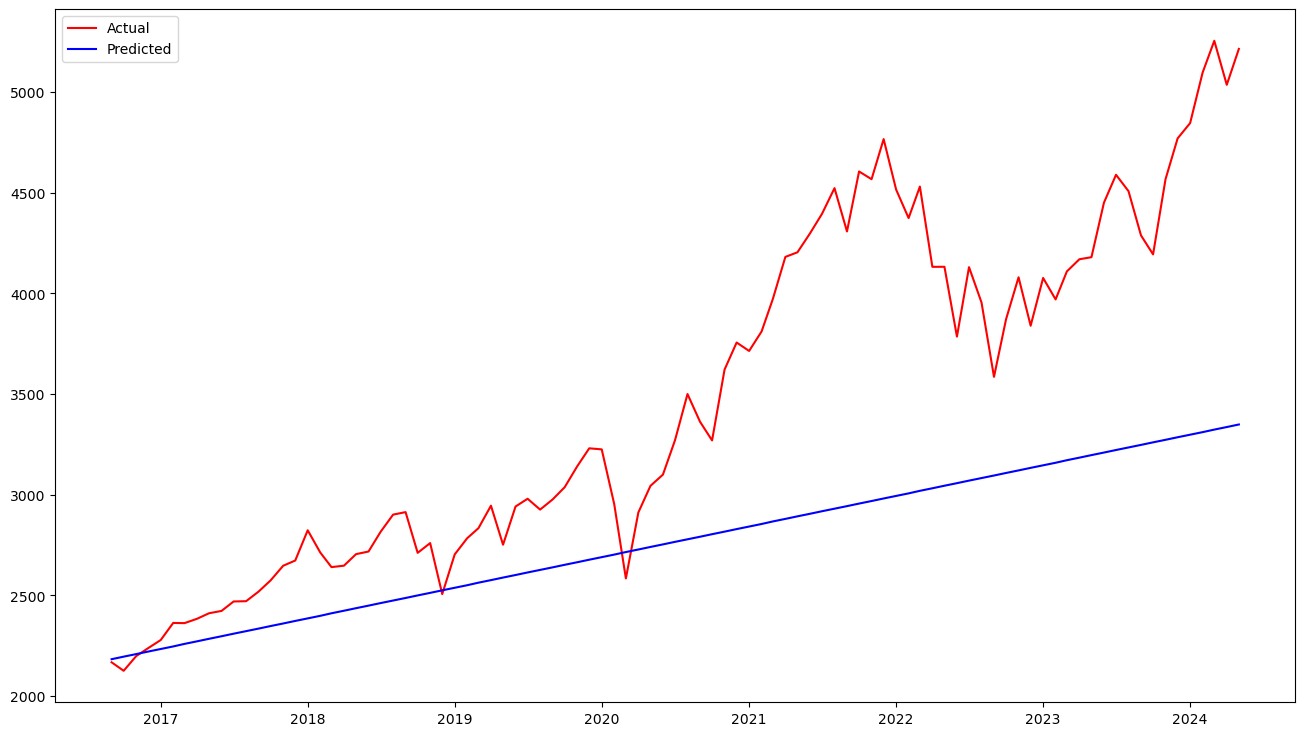

In [52]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,9))
plt.plot(pd.to_datetime(X_test), y_test, 'red', label='Actual')
plt.plot(pd.to_datetime(X_test), fit.forecast(X_test.shape[0]).values, 'blue', label="Predicted")
plt.legend()
plt.show()

In [58]:
X_test

array(['2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
       '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01',
       '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01',
       '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01',
       '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
       '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
       '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01',
       '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
       '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
       '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
       '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
       '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
       '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01',
       '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
       '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
       '2021-09-01', '2021-10-01', '2021-11-01', '2021-

In [53]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
y_pred = fit.forecast(X_test.shape[0])
print(f'The evaluations are as follows\nMean Squared Error: {mean_squared_error(y_test, y_pred)}\nMean Absolute Error: {mean_absolute_error(y_test, y_pred)}\nR2 Score: {r2_score(y_test, y_pred)}')

The evaluations are as follows
Mean Squared Error: 796342.7452688022
Mean Absolute Error: 708.0671160179871
R2 Score: -0.08839938368423295


In [142]:
to_save = pd.DataFrame({'Date':series.index.values[-y_pred.shape[0]:], 'Actual':y_test, 'Predicted':y_pred})
to_save.to_csv('ets.csv')

In [144]:
import pickle
fit.save('ets.pkl')

# Prophet

In [86]:
len(dates)

129

In [77]:
from prophet import Prophet

In [95]:
model = Prophet(yearly_seasonality=True, n_changepoints=50, seasonality_prior_scale=800, changepoint_prior_scale=10, seasonality_mode='multiplicative', interval_width=0.90)
model.fit(pd.DataFrame({'ds':X_train, 'y':y_train}))
future = model.make_future_dataframe(periods=len(X_test), freq='M')
forecast = model.predict(future)

00:23:01 - cmdstanpy - INFO - Chain [1] start processing
00:23:02 - cmdstanpy - INFO - Chain [1] done processing


In [99]:
forecast = forecast.tail(len(X_test))[['ds', 'yhat']]
forecast

,ds,yhat
320,2016-08-31,2123.040851
321,2016-09-30,2343.306408
322,2016-10-31,2353.936460
323,2016-11-30,2357.848962
324,2016-12-31,2232.615236
...,...,...
408,2023-12-31,3352.607405
409,2024-01-31,3241.963059
410,2024-02-29,3804.639740
411,2024-03-31,3834.515124


In [92]:
Prophet_temp = pd.DataFrame({'Timestamp': dates, 'Predicted': forecast['yhat'].values})
Prophet_temp['Timestamp'] = pd.to_datetime(Prophet_temp['Timestamp'])
Prophet_temp.head(5)

,Timestamp,Predicted
0,2016-09-01,2123.040851
1,2016-10-01,2343.306408
2,2016-11-01,2353.936460
3,2016-12-01,2357.848962
4,2017-01-01,2232.615236


In [94]:
import sqlite3
conn = sqlite3.connect(r'C:\Users\shami\OneDrive\Desktop\university\Data_Mining_Lab\project\git\data.db')
Prophet_temp.to_sql('Prophet_Prediction', conn, if_exists='replace', index=False)
conn.commit()
conn.close()

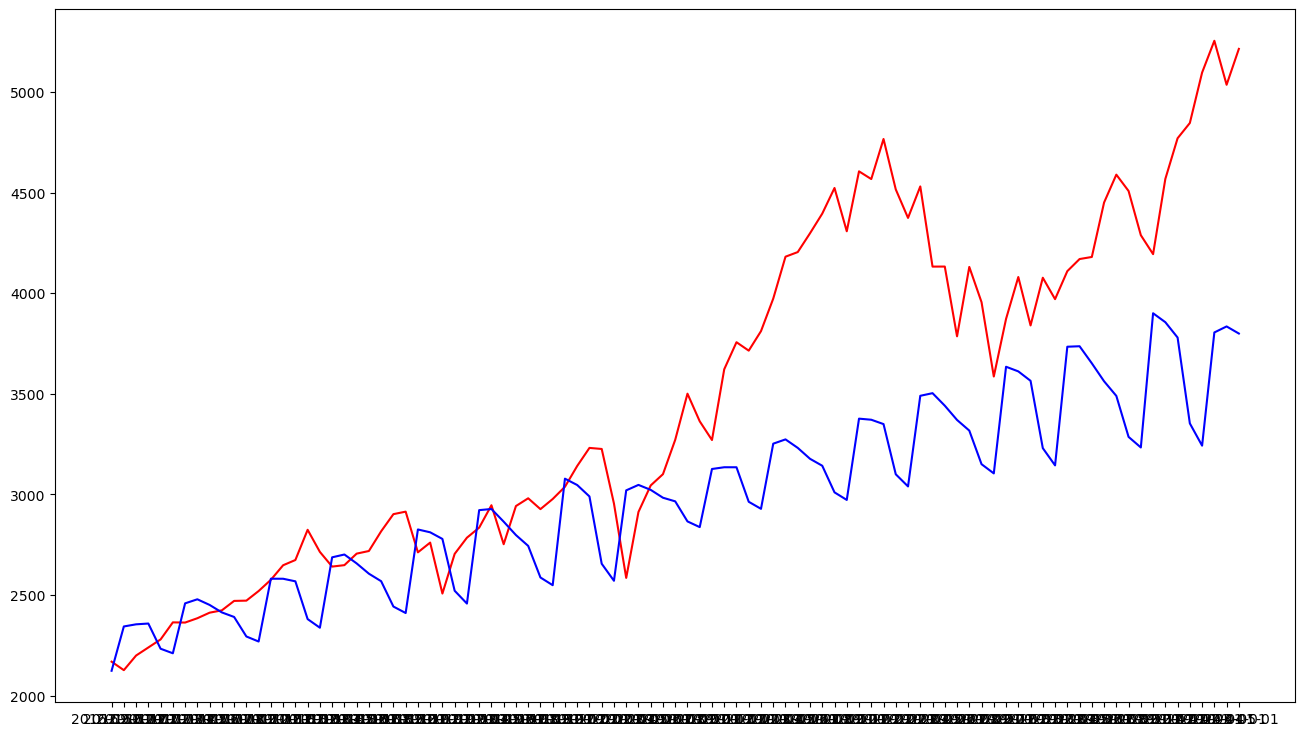

In [100]:
plt.figure(figsize=(16,9))
plt.plot(X_test, y_test, 'red', label='Training')
plt.plot(X_test, forecast['yhat'].values, 'blue', label="Testing")
plt.show()

In [82]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
y_pred = forecast['yhat']
print(f'The evaluations are as follows\nMean Squared Error: {mean_squared_error(y_test, y_pred)}\nMean Absolute Error: {mean_absolute_error(y_test, y_pred)}\nR2 Score: {r2_score(y_test, y_pred)}')

The evaluations are as follows
Mean Squared Error: 501481.1932221146
Mean Absolute Error: 533.5816398912167
R2 Score: 0.314601878556768


In [151]:
to_save = pd.DataFrame({'Date':forecast['ds'].values, 'Actual':y_test, 'Predicted':y_pred})
to_save.to_csv('Prophet.csv')

In [153]:
from prophet.serialize import model_to_json
with open('prophet.json', 'w') as fout:
    fout.write(model_to_json(model))

In [102]:
import sqlite3

# Connect to the SQLite database
conn = sqlite3.connect(r'C:\Users\shami\OneDrive\Desktop\university\Data_Mining_Lab\project\git\data.db')

# Create a cursor object to execute SQL commands
cursor = conn.cursor()

# Execute a query to get the names of all tables
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

# Fetch all rows from the result set
tables = cursor.fetchall()

# Extract table names from the result set
table_names = [table[0] for table in tables]

# Print the names of all tables
print("Tables in the database:")
for table_name in table_names:
    print(table_name)

# Close the cursor and connection
cursor.close()
conn.close()


Tables in the database:
Training
Testing
Arima_Prediction
Sarima_Prediction
ANN_Prediction
LSTM_Prediction
ETS_Prediction
Prophet_Prediction
